In [1]:

from random import randrange
import numpy as np
import pandas as pd 
from PIL import Image
import io
import os
from os import path
import time

import matplotlib.pyplot as plt
from matplotlib.image import imread


import findspark
from pyspark.sql import SparkSession
from pyspark import SparkContext

import tensorflow as tf
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array

from pyspark.sql.functions import col, pandas_udf, PandasUDFType, when


from pyspark.ml.linalg import Vectors, VectorUDT
from pyspark.sql.functions import udf
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.classification import LogisticRegression
from pyspark.ml import Pipeline
from pyspark.ml.classification import GBTClassifier
from pyspark.ml.feature import VectorAssembler, VectorIndexer,StringIndexer
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.feature import PCA

import warnings
warnings.filterwarnings('ignore')

2022-04-22 18:38:52.495753: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-04-22 18:38:52.495798: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


# chargement image

In [2]:
findspark.init()

In [3]:
from pyspark.sql import SparkSession
from pyspark import SparkContext
import yaml

BOT_CONFIG_FILE = 'env/auth.yaml'

with open(BOT_CONFIG_FILE, 'r') as config_file:
    config = yaml.load(config_file)



aws_id=config['AWS']['aws_id']
aws_secret=config['AWS']['aws_secret']


os.environ['PYSPARK_SUBMIT_ARGS'] = '--packages com.amazonaws:aws-java-sdk-pom:1.10.15,org.apache.hadoop:hadoop-aws:2.7.2 pyspark-shell'




sc = SparkContext()

spark = SparkSession \
    .builder \
    .appName("Python Spark SQL basic example") \
    .config("fs.s3a.impl","org.apache.hadoop.fs.s3a.S3AFileSystem")\
    .config("fs.s3a.access.key",aws_id)\
    .config("fs.s3a.secret.key",aws_secret)\
    .getOrCreate()

:: loading settings :: url = jar:file:/home/ubuntu/spark-3.1.2-bin-hadoop2.7/jars/ivy-2.4.0.jar!/org/apache/ivy/core/settings/ivysettings.xml


Ivy Default Cache set to: /home/ubuntu/.ivy2/cache
The jars for the packages stored in: /home/ubuntu/.ivy2/jars
com.amazonaws#aws-java-sdk-pom added as a dependency
org.apache.hadoop#hadoop-aws added as a dependency
:: resolving dependencies :: org.apache.spark#spark-submit-parent-49a3779e-4b46-42c4-afd1-16078ebe1dad;1.0
	confs: [default]
	found com.amazonaws#aws-java-sdk-pom;1.10.15 in central
	found org.apache.hadoop#hadoop-aws;2.7.2 in central
	found org.apache.hadoop#hadoop-common;2.7.2 in central
	found org.apache.hadoop#hadoop-annotations;2.7.2 in central
	found com.google.guava#guava;11.0.2 in central
	found com.google.code.findbugs#jsr305;3.0.0 in central
	found commons-cli#commons-cli;1.2 in central
	found org.apache.commons#commons-math3;3.1.1 in central
	found xmlenc#xmlenc;0.52 in central
	found commons-httpclient#commons-httpclient;3.1 in central
	found commons-logging#commons-logging;1.1.3 in central
	found commons-codec#commons-codec;1.4 in central
	found commons-io#comm

In [4]:
spark

In [5]:
def stringtopiece(string,pos1,pos2): 
#returns a piece of string based on the preceding and following characters    
    p1 = string.find(pos1)
    p2 = string.find(pos2)
    return string[p1+len(pos1):p2]

def preprocess(content):
    """
    Preprocesses raw image bytes for prediction.
    """
    img = Image.open(io.BytesIO(content)).resize([224, 224])
    arr = img_to_array(img)
    return preprocess_input(arr)

def featurize_series(model, content_series):
    """
    Featurize a pd.Series of raw images using the input model.
    :return: a pd.Series of image features
    """
    input = np.stack(content_series.map(preprocess))
    preds = model.predict(input)
    # For some layers, output features will be multi-dimensional tensors.
    # We flatten the feature tensors to vectors for easier storage in Spark DataFrames.
    output = [p.flatten() for p in preds]
    return pd.Series(output)

def featurize_series(model, content_series):
    """
    Featurize a pd.Series of raw images using the input model.
    :return: a pd.Series of image features
    """
    input = np.stack(content_series.map(preprocess))
    preds = model.predict(input)
    # For some layers, output features will be multi-dimensional tensors.
    # We flatten the feature tensors to vectors for easier storage in Spark DataFrames.
    output = [p.flatten() for p in preds]
    return pd.Series(output)

@pandas_udf('array<float>', PandasUDFType.SCALAR_ITER)
def featurize_udf(content_series_iter):
    '''
    This method is a Scalar Iterator pandas UDF wrapping our featurization function.
    The decorator specifies that this returns a Spark DataFrame column of type ArrayType(FloatType).

    :param content_series_iter: This argument is an iterator over batches of data, where each batch
                              is a pandas Series of image data.
    '''
    # With Scalar Iterator pandas UDFs, we can load the model once and then re-use it
    # for multiple data batches.  This amortizes the overhead of loading big models.
    model = model_fn()
    for content_series in content_series_iter:
        yield featurize_series(model, content_series)


In [6]:
images = spark.read.format("binaryFile") \
  .option("pathGlobFilter", "*.jpg") \
  .option("recursiveFileLookup", "true") \
  .load("s3a://imagedefruit/imagedefruit_5_5/All")

display(images.limit(5))

DataFrame[path: string, modificationTime: timestamp, length: bigint, content: binary]

In [7]:
images.show(3)

+--------------------+-------------------+------+--------------------+
|                path|   modificationTime|length|             content|
+--------------------+-------------------+------+--------------------+
|s3a://imagedefrui...|2022-04-16 15:56:09| 57050|[FF D8 FF E0 00 1...|
|s3a://imagedefrui...|2022-04-16 15:55:33| 55744|[FF D8 FF E0 00 1...|
|s3a://imagedefrui...|2022-04-16 15:56:09| 55710|[FF D8 FF E0 00 1...|
+--------------------+-------------------+------+--------------------+
only showing top 3 rows



# Pandas UDF

In [8]:
#Prepare model
model = ResNet50(include_top=False)
model.summary()  # verify that the top layer is removed

2022-04-22 18:39:20.098008: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-04-22 18:39:20.098056: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-04-22 18:39:20.098084: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (ip-172-31-43-148): /proc/driver/nvidia/version does not exist
2022-04-22 18:39:20.100233: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, None, None,   0           ['input_1[0][0]']                
                                3)                                                                
                                                                                                  
 conv1_conv (Conv2D)            (None, None, None,   9472        ['conv1_pad[0][0]']              
                                64)                                                        

In [9]:


bc_model_weights = sc.broadcast(model.get_weights())

def model_fn():
    """
    Returns a ResNet50 model with top layer removed and broadcasted pretrained weights.
    """
    model = ResNet50(weights=None, include_top=False)
    model.set_weights(bc_model_weights.value)
    return model

In [10]:
# Pandas UDFs on large records (e.g., very large images) can run into Out Of Memory (OOM) errors.
# If you hit such errors in the cell below, try reducing the Arrow batch size via `maxRecordsPerBatch`.
spark.conf.set("spark.sql.execution.arrow.maxRecordsPerBatch", "1024")

In [11]:
# We can now run featurization on our entire Spark DataFrame.
# NOTE: This can take a long time (about 10 minutes) since it applies a large model to the full dataset.
features_df = images.repartition(4).select(col("path"), featurize_udf("content").alias("features"))
features_df.write.mode("overwrite").parquet("s3a://imagedefruit/ml/Test")


2022-04-22 18:39:28.819550: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-04-22 18:39:28.819550: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-04-22 18:39:28.819597: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-04-22 18:39:28.819778: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-04-22 18:39:31.159843: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022

In [12]:
#MLLib needs some post processing of the features column format
list_to_vector_udf = udf(lambda l: Vectors.dense(l), VectorUDT())
features_df = features_df.select(
   col("path"),  
    list_to_vector_udf(features_df["features"]).alias("features")
)
features_df.show(3)

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


+--------------------+--------------------+
|                path|            features|
+--------------------+--------------------+
|s3a://imagedefrui...|[0.0,0.0,0.0,0.0,...|
|s3a://imagedefrui...|[0.0,0.0,0.0,0.0,...|
|s3a://imagedefrui...|[0.0,0.0,0.0,0.0,...|
+--------------------+--------------------+
only showing top 3 rows



In [13]:
rdd2=features_df.rdd.map(lambda x:(
    stringtopiece(x[0],"/All/","/r"),
    x[1]
    ))  
features_df=rdd2.toDF(["Target","features"])


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


In [14]:
# map college name with colege number
# using with column method along with when module
features_df=features_df.withColumn("Target_number", 
                      when(col("Target")=='apple_6', 0)
                     .when(col("Target")=='carrot_1', 1)
                     .when(col("Target")=='zucchini_1', 2)
                     .when(col("Target")=='pear_1', 3)
                     .otherwise(4))
features_df.show(3)

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


+--------+--------------------+-------------+
|  Target|            features|Target_number|
+--------+--------------------+-------------+
|  pear_1|[0.0,0.0,0.0,0.0,...|            4|
|  pear_1|[0.0,0.0,0.0,0.0,...|            4|
|carrot_1|[0.0,0.0,0.0,0.0,...|            2|
+--------+--------------------+-------------+
only showing top 3 rows



In [15]:

# OMITTED HERE
# You need to add the labels to your dataset based on the path of your images

# splitting in to training, validate and test set
df_train_split,  df_test_split =  features_df.randomSplit([0.5, 0.5],42)  

In [16]:
Me_PCA=PCA(k=10,inputCol='features')
Me_PCA.setOutputCol("pca_features")

Me_PCA.fit(df_train_split)


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
2022-04-22 18:40:28.134800: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-04-22 18:40:28.137116: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_no

PCAModel: uid=PCA_ffad4af0a177, k=10

In [17]:
from pyspark.ml.classification import RandomForestClassifier

#Here we start to train the tail of the model

# This concatenates all feature columns into a single feature vector in a new column "featuresModel".
vectorAssembler = VectorAssembler(inputCols=['pca_features'], outputCol="featuresModel")

#labelIndexer = StringIndexer(inputCol="Target", outputCol="indexedTarget").fit(features_df)

lr = RandomForestClassifier(labelCol="Target_number", featuresCol="featuresModel")

In [18]:
# define a pipeline model
sparkdn = Pipeline(stages=[Me_PCA,vectorAssembler,lr])
spark_model = sparkdn.fit(df_train_split) # start fitting or training

# evaluating the model
predictions = spark_model.transform(df_test_split)

# Select example rows to display.
predictions.select("prediction", "Target", "features").show(5)

# Select (prediction, true label) and compute test error
evaluator = MulticlassClassificationEvaluator(
    labelCol="Target_number", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)
print("Accuracy = %g" % (accuracy))

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set

+----------+-----------------+--------------------+
|prediction|           Target|            features|
+----------+-----------------+--------------------+
|       2.0|          apple_6|[0.0,0.0,0.0,0.0,...|
|       1.0|          apple_6|[0.0,0.0,0.0,0.0,...|
|       2.0|         carrot_1|[0.0,0.0,0.0,0.0,...|
|       2.0|         carrot_1|[0.0,0.0,0.0,0.0,...|
|       5.0|eggplant_violet_1|[0.0,0.0,0.0,0.0,...|
+----------+-----------------+--------------------+
only showing top 5 rows



22/04/22 19:00:51 WARN DAGScheduler: Broadcasting large task binary with size 7.8 MiB
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimen

Accuracy = 0.878788


In [19]:
predictions.write.mode("overwrite").parquet("s3a://imagedefruit/ml/prediction")

22/04/22 19:01:18 WARN DAGScheduler: Broadcasting large task binary with size 8.1 MiB
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimen

In [20]:
predictions.show(3)

22/04/22 19:01:51 WARN DAGScheduler: Broadcasting large task binary with size 7.8 MiB
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


+--------+--------------------+-------------+--------------------+--------------------+--------------------+--------------------+----------+
|  Target|            features|Target_number|        pca_features|       featuresModel|       rawPrediction|         probability|prediction|
+--------+--------------------+-------------+--------------------+--------------------+--------------------+--------------------+----------+
| apple_6|[0.0,0.0,0.0,0.0,...|            1|[-54.964467284840...|[-54.964467284840...|[0.0,5.0,6.0,2.0,...|[0.0,0.25,0.3,0.1...|       2.0|
| apple_6|[0.0,0.0,0.0,0.0,...|            1|[-77.440327022277...|[-77.440327022277...|[0.0,14.0,0.0,3.0...|[0.0,0.7,0.0,0.15...|       1.0|
|carrot_1|[0.0,0.0,0.0,0.0,...|            2|[-34.410948964750...|[-34.410948964750...|[0.0,0.0,16.0,1.0...|[0.0,0.0,0.8,0.05...|       2.0|
+--------+--------------------+-------------+--------------------+--------------------+--------------------+--------------------+----------+
only showing 

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set

[0.34441335677186924,0.1550057309270719,0.10421781728461486,0.06632625852561087,0.03370875634905077,0.03225175719723677,0.028933212772967964,0.025100889649026934,0.022199923155653754,0.020582043244963353,0.01666334592648547,0.01612650273071141,0.015174181021282008,0.01303957669291086,0.012822915535551593,0.009640591224414012,0.008084312995047601,0.00653694413735895,0.005680487072347853,0.0054206755877408115,0.0047228059368309245,0.004562510960935859,0.004270942589806692,0.004120105958199014,0.0038931343410644457,0.003846774749037165,0.0037686167886566793,0.0034089253643029152,0.003212330376504784,0.0027287002781865477,0.002674322718217877,0.002381130628028895,0.0023121137452804643,0.0019382542668346862,0.0018926637149606772,0.0018636136623971988,0.0018113199734493435,0.0016693507623579162,0.001512771777549671,0.0014803326054809436]


Text(0, 0.5, 'cumulative explained variance')

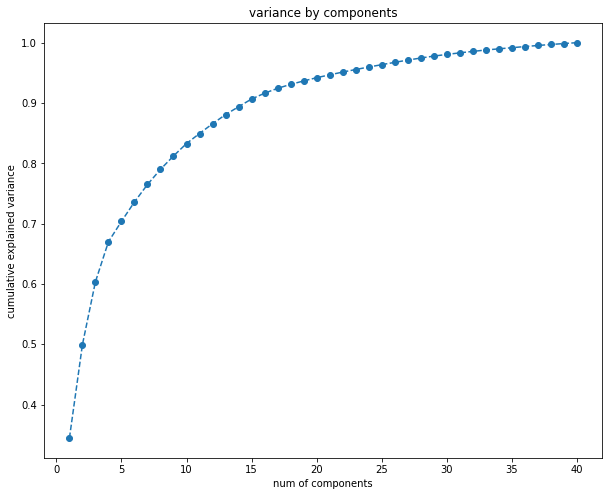

In [21]:
import matplotlib.pyplot as plt 

# used vector assembler to create the input the vector 
#vectorAssembler = VectorAssembler(inputCols=['features'], outputCol='pcaInput')

#df = vectorAssembler.transform(features_df) # fetch data into vector assembler
pca = PCA(k=40, inputCol="features", outputCol="feature") # here I Have defined maximum number of features that I have
pcaModel = pca.fit(features_df) # fit the data to pca to make the model
print(pcaModel.explainedVariance) # here it will explain the variances
cumValues = pcaModel.explainedVariance.cumsum() # get the cumulative values
# plot the graph 
plt.figure(figsize=(10,8))
plt.plot(range(1,41), cumValues, marker = 'o', linestyle='--')
plt.title('variance by components')
plt.xlabel('num of components')
plt.ylabel('cumulative explained variance')